In [1]:
pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 57.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=6b30db946856aaed2345fd610bd51ca637b052552d69d28280ebd4d23cb3ec4c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
from pyspark import SparkContext
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, TimestampType, DoubleType
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col, regexp_replace, split, lit, udf
from pyspark.ml.feature import StringIndexer, MinMaxScaler
import pyspark.sql.functions as fn
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np

## Dataset load

In [3]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
schema = StructType([
    StructField("date",TimestampType(),True),
    StructField("open",FloatType(),True), 
    StructField("high",FloatType(),True), 
    StructField("low", FloatType(), True), 
    StructField("close", FloatType(), True), 
    StructField("adj_close", FloatType(), True),
    StructField("volume", IntegerType(), True)
  ])

In [5]:
# the path may need to modify
data = spark.read.csv('/content/drive/MyDrive/DATA 228 Big Data/228_project/final submission folder/AAPL.csv', header=True, schema=schema)
data.show(5)

+-------------------+--------+--------+--------+--------+---------+---------+
|               date|    open|    high|     low|   close|adj_close|   volume|
+-------------------+--------+--------+--------+--------+---------+---------+
|1980-12-12 00:00:00|0.128348|0.128906|0.128348|0.128348|   0.1006|469033600|
|1980-12-15 00:00:00| 0.12221| 0.12221|0.121652|0.121652| 0.095352|175884800|
|1980-12-16 00:00:00|0.113281|0.113281|0.112723|0.112723| 0.088353|105728000|
|1980-12-17 00:00:00|0.115513|0.116071|0.115513|0.115513|  0.09054| 86441600|
|1980-12-18 00:00:00|0.118862| 0.11942|0.118862|0.118862| 0.093165| 73449600|
+-------------------+--------+--------+--------+--------+---------+---------+
only showing top 5 rows



## Feature selection

narrow down the samples to the date after 2020-01-01

In [ ]:
# keep only date and close
df_close = data.drop('open', 'high', 'low', 'adj_close', 'volume')
df_close = df_close.where(data.date >= '2020-01-01')
print('number of samples: ', df_close.count())
df_close.show(5)

number of samples:  425
+-------------------+-------+
|               date|  close|
+-------------------+-------+
|2020-01-02 00:00:00|75.0875|
|2020-01-03 00:00:00|74.3575|
|2020-01-06 00:00:00|  74.95|
|2020-01-07 00:00:00|74.5975|
|2020-01-08 00:00:00|75.7975|
+-------------------+-------+
only showing top 5 rows



## Data normalization

In [ ]:
# data normalization
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


unlist = udf(lambda x: float(list(x)[0]), FloatType())

assembler = VectorAssembler(inputCols=['close'],outputCol='close_vect')
scaler = MinMaxScaler(inputCol='close_vect', outputCol='close_scaled')
pipeline = Pipeline(stages=[assembler, scaler])
df_close = pipeline.fit(df_close).\
transform(df_close).withColumn('close_scaled', 
                               unlist('close_scaled')).drop('close_vect', 'close')
df_close.show(5)

+-------------------+------------+
|               date|close_scaled|
+-------------------+------------+
|2020-01-02 00:00:00|  0.18882181|
|2020-01-03 00:00:00|  0.18156514|
|2020-01-06 00:00:00|  0.18745494|
|2020-01-07 00:00:00|  0.18395093|
|2020-01-08 00:00:00|  0.19587962|
+-------------------+------------+
only showing top 5 rows



## Train test set split

split based on the date 2021-04-01

In [ ]:
train_data = df_close.where(data.date < '2020-09-15').drop('date')
test_data = df_close.where((data.date >= '2020-09-15') & (data.date < '2020-12-31')).drop('date')

In [ ]:
train_data.show(5)
print('train set volume: ', train_data.count())

+------------+
|close_scaled|
+------------+
|  0.18882181|
|  0.18156514|
|  0.18745494|
|  0.18395093|
|  0.19587962|
+------------+
only showing top 5 rows

train set volume:  177


In [ ]:
test_data.show(5)
print('test set volume: ', test_data.count())

+------------+
|close_scaled|
+------------+
|   0.5909441|
|   0.5570466|
|  0.53925294|
|   0.5044608|
|   0.5366684|
+------------+
only showing top 5 rows

test set volume:  75


## Data set build

In [ ]:
train = train_data.toPandas().values
test = test_data.toPandas().values

In [ ]:
def dataset_generation(data, time_step):
  data_x = []
  data_y = []
  for i in range(len(data)- time_step - 1):
    temp = data[i : i + time_step, 0]
    data_x.append(temp)
    data_y.append(data[i + time_step, 0])
  return np.array(data_x), np.array(data_y)

In [ ]:
time_step = 15
X_train, y_train = dataset_generation(train, time_step)
X_test, y_test = dataset_generation(test, time_step)

## Model Train and Test

1. Pyspark LinearRegression

In [ ]:
# build dataset for pyspark
x_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
x_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

In [ ]:
df_train = pd.concat([x_train_df, y_train_df], axis=1)
df_test = pd.concat([x_test_df, y_test_df], axis=1)

In [ ]:
col_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
df_train.columns = col_names
df_test.columns = col_names

In [ ]:
train_spark = spark.createDataFrame(df_train)
test_spark = spark.createDataFrame(df_test)

In [ ]:
from pyspark.ml.feature import VectorAssembler

cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
vector_assembler = VectorAssembler(inputCols=cols, outputCol='standard_features')
train_data = vector_assembler.transform(train_spark)
test_data = vector_assembler.transform(test_spark)

In [ ]:
train_data.show(2)

+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+--------------------+
|                  0|                  1|                  2|                  3|                  4|                  5|                  6|                  7|                  8|                  9|                 10|                 11|                 12|                13|                14|                 15|   standard_features|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------

In [ ]:
# save test_data
test_data.toPandas().to_csv('/content/drive/MyDrive/DATA 228 Big Data/228_project/xzy/test_data.csv')

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
# train
lr = LinearRegression(maxIter=10, 
                      labelCol='15', 
                      featuresCol='standard_features')
lrModel = lr.fit(train_data)

In [ ]:
lrSummary = lrModel.summary
print('Training RMSE for LinearRegression model = ', lrSummary.rootMeanSquaredError)

Training RMSE for LinearRegression model =  0.024934052362187355


In [ ]:
# test
from pyspark.ml.evaluation import RegressionEvaluator

lr_predictions = lrModel.transform(test_data)
lr_eval = RegressionEvaluator(labelCol='15', metricName='rmse')
rmse = lr_eval.evaluate(lr_predictions)
print('Test RMSE for LinearRegression model = ', rmse)

Test RMSE for LinearRegression model =  0.02846050209615025


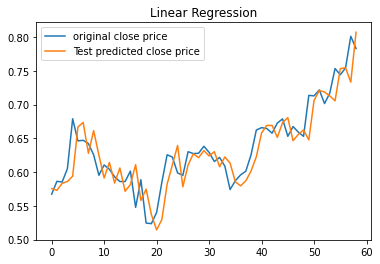

In [ ]:
# plot prediction vs original
lr_pred = lr_predictions.toPandas()['prediction']
plt.plot(y_test, label='original close price')
plt.plot(lr_pred, label='Test predicted close price')
plt.title('Linear Regression')
plt.legend()
plt.show()

In [ ]:
# save model
lrModel.write().overwrite().save('/content/drive/MyDrive/DATA 228 Big Data/228_project/xzy/lr_model')

2. Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='standard_features',
                           labelCol='15')
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_eval = RegressionEvaluator(labelCol='15', metricName='rmse')
rmse = rf_eval.evaluate(rf_predictions)
print('Test RMSE for Random Forest model = ', rmse)

Test RMSE for Random Forest model =  0.05417696356005632


fine tune

In [ ]:
import pyspark.ml.tuning as tune

rf = RandomForestRegressor(featuresCol='standard_features',
                           labelCol='15')

rf_eval = RegressionEvaluator(labelCol='15', metricName='rmse')

grid = tune.ParamGridBuilder().addGrid(
rf.maxDepth, [5, 10, 15, 20, 25, 30]
).addGrid(
rf.numTrees, [5, 10, 20, 30]
).build()

cv = tune.CrossValidator(estimator=rf, 
                         estimatorParamMaps=grid, 
                         evaluator=rf_eval)

rf_cv = cv.fit(train_data)

results = rf_cv.transform(test_data)

results = [([{key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())], 
            metric) 
for params, metric in zip(rf_cv.getEstimatorParamMaps(), rf_cv.avgMetrics)]
sorted(results, key=lambda el: el[1], reverse=True)[0]

([{'maxDepth': 5}, {'numTrees': 5}], 0.03770665030623331)

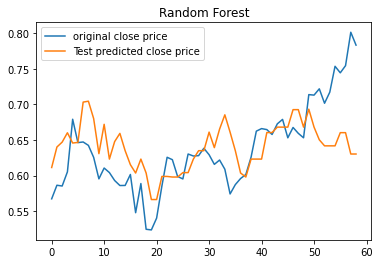

In [ ]:
rf_final = RandomForestRegressor(featuresCol='standard_features',
                           labelCol='15',
                         maxDepth=5,
                         numTrees=5)
rf_model_final = rf_final.fit(train_data)
rf_predictions_final = rf_model_final.transform(test_data)

# plot prediction vs original
rf_pred = rf_predictions_final.toPandas()['prediction']
plt.plot(y_test, label='original close price')
plt.plot(rf_pred, label='Test predicted close price')
plt.title('Random Forest')
plt.legend()
plt.show()

3. Gradient-boosted tree regression

In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol='standard_features',
                           labelCol='15')
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_eval = RegressionEvaluator(labelCol='15', metricName='rmse')
rmse = gbt_eval.evaluate(gbt_predictions)
print('Test RMSE for Gradient-boosted tree regression model = ', rmse)

Test RMSE for Gradient-boosted tree regression model =  0.08894107678869265


fine tune

In [ ]:
grid = tune.ParamGridBuilder().addGrid(
gbt.maxDepth, [5, 10, 15, 20, 25, 30]
).addGrid(
gbt.maxIter, [5, 10, 20, 30, 40, 50] 
).build()

cv = tune.CrossValidator(estimator=gbt, 
                         estimatorParamMaps=grid, 
                         evaluator=gbt_eval)

gbt_cv = cv.fit(train_data)

results = gbt_cv.transform(test_data)

results = [([{key.name: paramValue} for key, paramValue in zip(params.keys(), params.values())], 
            metric) 
for params, metric in zip(gbt_cv.getEstimatorParamMaps(), gbt_cv.avgMetrics)]
sorted(results, key=lambda el: el[1], reverse=True)[0]

([{'maxDepth': 5}, {'maxIter': 50}], 0.04095246934016352)

In [ ]:
gbt_final = GBTRegressor(featuresCol='standard_features',
                           labelCol='15',
                         maxDepth=5,
                         maxIter=50)
gbt_model_final = gbt_final.fit(train_data)
gbt_predictions_final = gbt_model_final.transform(test_data)

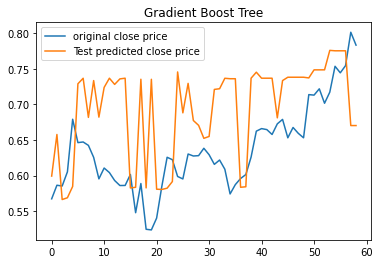

In [ ]:
# plot prediction vs original
gbt_pred = gbt_predictions_final.toPandas()['prediction']
plt.plot(y_test, label='original close price')
plt.plot(gbt_pred, label='Test predicted close price')
plt.title('Gradient Boost Tree')
plt.legend()
plt.show()

## Demo

In [11]:
# define path first
# then run the following code
model_path = '/content/drive/MyDrive/DATA 228 Big Data/228_project/final submission folder/lr_model'
data_path = '/content/drive/MyDrive/DATA 228 Big Data/228_project/final submission folder/ml_test_data.csv'

In [12]:
from pyspark.ml.regression import LinearRegressionModel
# load model
lr_model = LinearRegressionModel.load(model_path)

In [13]:
# read test data from csv file
test_import = spark.read.csv(data_path, header=True, inferSchema =True).drop('standard_features')

In [14]:
from pyspark.ml.feature import VectorAssembler

cols = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14']
vector_assembler = VectorAssembler(inputCols=cols, outputCol='standard_features')
lr_test = vector_assembler.transform(test_import)

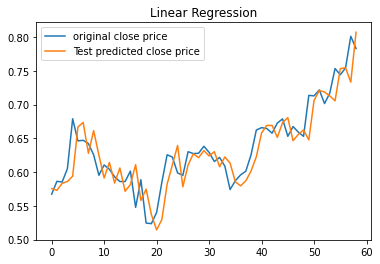

In [15]:
pred = lr_model.transform(lr_test)
lr_pred = pred.toPandas()['prediction']
lr_label = pred.toPandas()['15']
plt.plot(lr_label, label='original close price')
plt.plot(lr_pred, label='Test predicted close price')
plt.title('Linear Regression')
plt.legend()
plt.show()